In [ ]:
# three data sets (small, medium, big)
# objective function: h = n repetitions of f,  where f = g(t)-g(t+T)   
# full data identification (time window defined but not used )
# Identifies "a repetitive" pattern on the full data set ( it also works on a smaller data window ) and campares 
# time window width = h function length

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import pprint

import cma

In [40]:
# import data -- first data set
data_frame = pd.read_csv('All_data.csv', sep=',')

In [41]:
data = data_frame.to_numpy()
t, v = data[:, 0], data[:, 1]

In [42]:
# data_frame2 = pd.read_csv('t0.csv', sep=',')

In [43]:
# data2 = data_frame2.to_numpy()
# t0_idx, t0  = data2[:, 0], data2[:, 1]
# t0_idx = np.array([int(t0_id) for t0_id in t0_idx])

<IPython.core.display.Javascript object>


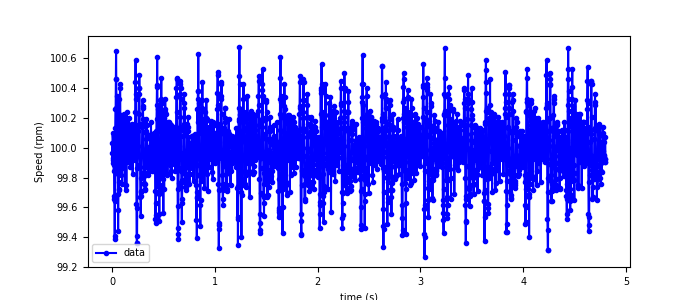

Text(0.5, 0, 'time (s)')

Text(0, 0.5, 'Speed (rpm)')

In [53]:
# plot data
plt.rcParams['figure.figsize'] = [7, 3]
# %matplotlib notebook

#plt.plot(t, v, 'b-o', t[t0_idx], 100*np.ones(len(t0)),'r*')
plt.plot(t, v, '-b.')
plt.xlabel('time (s)')
plt.ylabel('Speed (rpm)')
plt.legend(['data'])
plt.show()

In [9]:
# expected value of the parameters:
# A = 0.6
# t0 = 0.216
# tau = 9
# omega = 2*np.pi*26
# c = 100
# t1 = 0.41
# t2 = 0.216
# T = 0.5
# TT = 1

# n_max = 4



def media(v):
   return sum(v)/len(v)

def RMSE(v,v_hat):
      return np.sqrt(((v-v_hat)**2).mean())

def step(x):
    return 1*(x>0)



## 'couple' pattern: interpolating func f = g(t)-g(t+T)  
# where g = A *step(t-t0-t2) *step(t1-(t-t0)) *np.exp(-1*(t-t0-t2)*tau) *np.sin(omega*(t-t0))
# single positive:  g(t)
# single negative: -g(t)

# single positive
def g(A, t0, tau, omega, c, t1, t2): # c not used here
    return A *step(t-t0-t2) *step(t1-(t-t0)) *np.exp(-1*(t-t0-t2)*tau) *np.sin(omega*(t-t0))

# single positive + single negative
def f(A, t0, tau, omega, c, t1, t2, T):   #par = [A, t0, tau, omega, c, t1, t2, T]
    return (g(A, t0, tau, omega, c, t1, t2)-g(A, t0+T, tau, omega, c, t1, t2))+c

# objective function defined on 'couple' pattern
def obj2(par):
    [A, t0, tau, omega, c, t1, t2, T] = par
    return RMSE(v, f(A, t0, tau, omega, c, t1, t2, T))



## 'repetitive' pattern: interpolating func h = f(t) + f(t+TT)+ ...  
# h = n repetitons of (single positive + single negative) couple
# h(A, t0, tau, omega, c, t1, t2, T, TT) =   
#    (f(A, t0, tau, omega, 0, t1, t2, T) +f(A, t0+TT, tau, omega, 0, t1, t2, T)) +c

# 'repetitive' pattern:
def h(A, t0, tau, omega, c, t1, t2, T, TT): 
    n_max = 5 # int(par[8])
    a = c
    for n in range (0,n_max):
        period = n*TT
        a = a + f(A, t0+period, tau, omega, 0, t1, t2, T)
    return a 

# objective function defined on 'repetitive' pattern
def obj3(par):
    [A, t0, tau, omega, c, t1, t2, T, TT] = par
    return RMSE(v, h(A, t0, tau, omega, c, t1, t2, T, TT))



# def g(A, t0, tau, omega, c, t1, t2): # c not used here
#     return A *step(t_after-t0-t2) *step(t1-(t_after-t0)) *np.exp(-1*(t_after-t0-t2)*tau) *np.sin(omega*(t_after-t0))

# def obj3_after(par):
#     [A, t0, tau, omega, c, t1, t2, T, TT] = par
#     return RMSE(v_after, h(A, t0, tau, omega, c, t1, t2, T, TT))


Text(0.5, 0, 'time (s)')

Text(0, 0.5, 'Speed (rpm)')

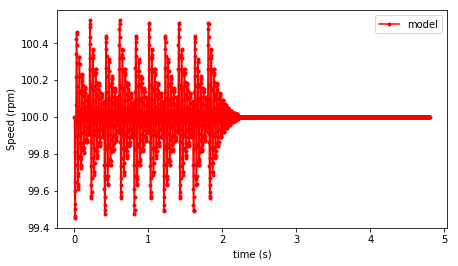

In [10]:
# for debug:
# interpolating function plot

#plt.rcParams['figure.figsize'] = [6, 3]
# %matplotlib inline

# expected value of the parameters
A = -0.6
t0  = 0
tau = 9
omega = 2*np.pi*26
c = 100
t1 = 0.41
t2 = 0
T = 0.20
TT = 0.40
# n_max = 12

#par = [A, t0, tau, omega, c, t1, t2, T]

plt.plot(t, h(A, t0, tau, omega, c, t1, t2, T, TT), '-r.') #,t, v, 'b-o')
plt.xlabel('time (s)')
plt.ylabel('Speed (rpm)')
plt.legend(['model'])
plt.show()

Text(0.5, 0, 'time (s)')

Text(0, 0.5, 'Speed (rpm)')

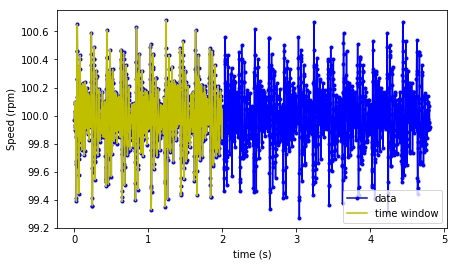

In [11]:
# time window on data

T = 0.20 # period
dT = 0.002; # sampling time

num = 10
window_samples = int(num*T/0.002) 

v_w = v[0:window_samples]
t_w = t[0:window_samples]

plt.plot(t,v, '-b.',t_w,v_w,'-y')#,t, v, 'b-o')
plt.xlabel('time (s)')
plt.ylabel('Speed (rpm)')
plt.legend(['data','time window'])
plt.show()

t = t_w
v = v_w

t_1, v_1 = t, v 


In [12]:
# domain of the variables

#domain= [[m0, m1, m2, m3, m4, m5, m6],[M0, M1, M2, M3, M4, M5, M6]]
A_b = [-(max(v)-min(v))/2, (max(v)-min(v))/2]
t0_b = [min(t), max(t)]
tau_b = [5, 30]
omega_b = [ 2*np.pi*1, 2*np.pi*40]
c_b = [min(v), max(v)]
t1_b = [0, 0.204] # to be set
t2_b = [0, 0.204/2] # to be set
T_b = [min(t), max(t)] # to be set
TT_b = [min(t), max(t)] # to be set

domain = np.array([[A_b[0], t0_b[0], tau_b[0], omega_b[0], c_b[0], t1_b[0], t2_b[0], T_b[0], TT_b[0]], [A_b[1], t0_b[1], tau_b[1], omega_b[1], c_b[1], t1_b[1], t2_b[1], T_b[1], TT_b[1]]] )


In [13]:
# obj3 -- 'repetitive' pattern identification

#x0 = (m+M)/2
#sigma0 = (M-m)/4
x0 = (domain[0]+domain[1])/2
sigma0 = (domain[1]-domain[0])/4    


#res = cma.CMAEvolutionStrategy(x0, 1, inopts={'popsize':2000, 'CMA_stds':sigma0,'fixed_variables':{5:0.218, 6:0, 7:0.204}}) 
res = cma.CMAEvolutionStrategy(x0, 1, inopts = {'popsize':3500, 'CMA_stds':sigma0, 'bounds':[domain[0], domain[1]], 'fixed_variables':{ 7:0.20, 8:0.4}}) 
res.optimize(obj3, iterations=2000)

(1750_w,3500)-aCMA-ES (mu_w=881.6,w_1=0%) in dimension 7 (seed=1008889, Wed Mar  6 13:09:03 2019)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1   3500 1.984677809379996e-01 1.0e+00 9.92e-01  2e-02  6e+01 0:06.5
    2   7000 1.740429180576433e-01 4.7e+00 1.02e+00  3e-02  6e+01 0:13.0
    3  10500 1.810930986146574e-01 1.3e+01 1.06e+00  2e-02  6e+01 0:19.7
    4  14000 1.892902497684443e-01 2.3e+01 1.14e+00  1e-02  6e+01 0:26.3
    5  17500 1.747074232793001e-01 3.7e+01 1.25e+00  1e-02  6e+01 0:32.6
    6  21000 1.630766746657286e-01 4.5e+01 1.34e+00  1e-02  6e+01 0:39.0
    7  24500 1.734755783196385e-01 5.6e+01 1.43e+00  9e-03  6e+01 0:45.6
    8  28000 1.742643877663716e-01 6.6e+01 1.51e+00  8e-03  5e+01 0:52.9
   10  35000 1.707457801164470e-01 7.9e+01 1.64e+00  8e-03  4e+01 1:06.3
   11  38500 1.697661313869402e-01 8.1e+01 1.70e+00  8e-03  4e+01 2:46.8
   13  45500 1.684564326504052e-01 8.5e+01 1.82e+00  7e-03  3e+01 2:59.9
   15  52500 1.570227075714

<IPython.core.display.Javascript object>


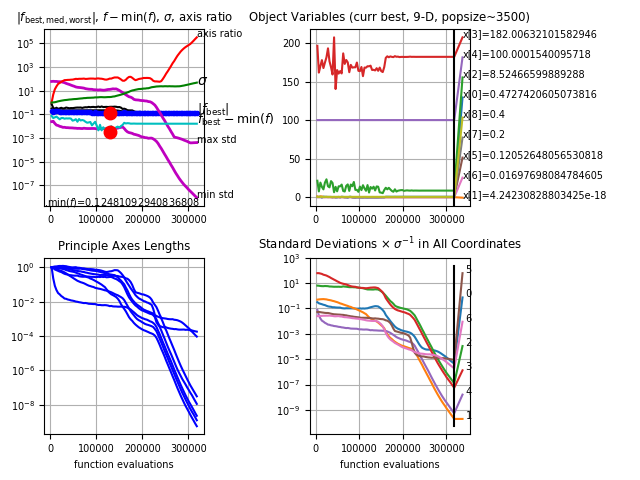

In [14]:
%matplotlib notebook
cma.plot()

In [15]:
res.result_pretty()

termination on tolfunhist=1e-12
final/bestever f-value = 1.411073e-01 1.248109e-01
incumbent solution: [0.4730140876634637, 2.945673086369549e-19, 8.524667829852977, 182.0063208736763, 100.00015399891292, 0.12104091887184022, 0.016909474867853203, 0.2, 0.4]
std deviation: [0.00021318924060894224, 9.308319097972457e-09, 5.931682980703012e-06, 2.6670859636735816e-06, 2.5857784951000855e-08, 0.0004173422632862238, 9.091591243909559e-05]


CMAEvolutionStrategyResult(xbest=array([-5.15055692e-01,  1.26363915e-02,  1.10186475e+01,  1.64982094e+02,
        9.99932367e+01,  2.02773386e-01,  6.99672699e-03,  2.00000000e-01,
        4.00000000e-01]), fbest=0.12481092940836808, evals_best=128405, evaluations=318500, iterations=91, xfavorite=array([ 4.73014088e-01, -5.00000002e-02,  8.52466783e+00,  1.82006321e+02,
        1.00000150e+02,  1.21040919e-01,  8.15406240e-03,  2.00000000e-01,
        4.00000000e-01]), stds=array([2.13189241e-04, 9.30831910e-09, 5.93168298e-06, 2.66708596e-06,
       2.58577850e-08, 4.17342263e-04, 9.09159124e-05]))

In [17]:
out_1 = res.result.xbest

print('out = [A, t0, tau, omega, c, t1, t2, T] =' ) 
print('    =', out_1)
print('expected values = [-0.6, 0, 9, 2*pi*26, 100, 0.218, 0, 0.204]')
print('error =', obj3(out_1))

out = [A, t0, tau, omega, c, t1, t2, T] =
    = [-5.15055692e-01  1.26363915e-02  1.10186475e+01  1.64982094e+02
  9.99932367e+01  2.02773386e-01  6.99672699e-03  2.00000000e-01
  4.00000000e-01]
expected values = [-0.6, 0, 9, 2*pi*26, 100, 0.218, 0, 0.204]
error = 0.12481092940836808


<IPython.core.display.Javascript object>


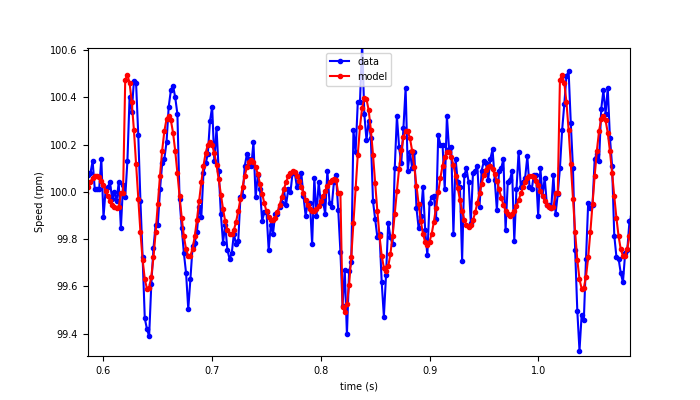

Text(0.5, 0, 'time (s)')

Text(0, 0.5, 'Speed (rpm)')

In [45]:
# plot resulting function

[A, t0, tau, omega, c, t1, t2, T, TT] = out_1

#plt.plot(t, h(out), '-ro')
plt.plot(t, v, '-b.', t, h(A, t0, tau, omega, c, t1, t2, T, TT), '-r.')
plt.xlabel('time (s)')
plt.ylabel('Speed (rpm)')
plt.legend(['data','model'])
plt.show()

<IPython.core.display.Javascript object>


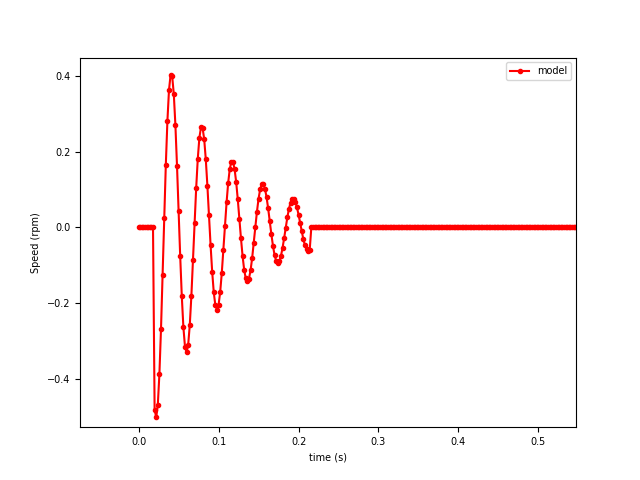

Text(0.5, 0, 'time (s)')

Text(0, 0.5, 'Speed (rpm)')

In [19]:
# for debug
plt.plot(t, g(A, t0,tau, omega, c, t1, t2), '-r.')#,t, v, 'b-o')
plt.xlabel('time (s)')
plt.ylabel('Speed (rpm)')
plt.legend(['model'])
plt.show()

In [20]:
baklash_est_1 = abs(out_1[0])
baklash_est_1

0.5150556915914648

In [ ]:
# new datas

In [21]:
# import data -- -- second data set
data_frame_2 = pd.read_csv('All_data_2.csv', sep=',')

In [22]:
data_2 = data_frame_2.to_numpy()
t_2, v_2 = data_2[:, 0], data_2[:, 1]

In [23]:
t, v = t_2, v_2

<IPython.core.display.Javascript object>


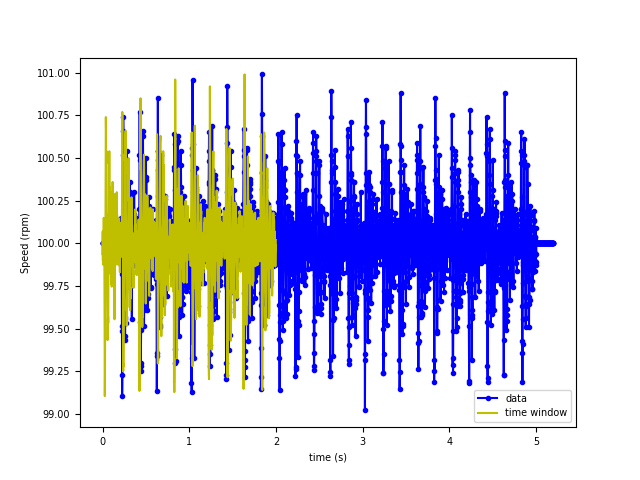

Text(0.5, 0, 'time (s)')

Text(0, 0.5, 'Speed (rpm)')

In [24]:
# time window on data

T = 0.20 # period
dT = 0.002; # sampling time

num = 10
window_samples = int(num*T/0.002) 

v_w = v[100:window_samples+100]  # sistemare l'inizio del daatset
t_w = t[0:window_samples]

plt.plot(t,v, '-b.',t_w,v_w,'-y')#,t, v, 'b-o')
plt.xlabel('time (s)')
plt.ylabel('Speed (rpm)')
plt.legend(['data','time window'])
plt.show()

t = t_w
v = v_w

<IPython.core.display.Javascript object>


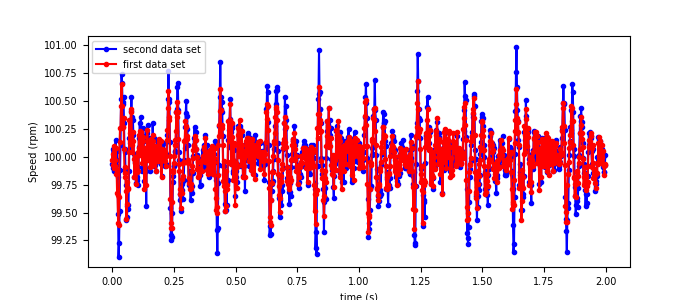

Text(0.5, 0, 'time (s)')

Text(0, 0.5, 'Speed (rpm)')

In [25]:
# display data
plt.rcParams['figure.figsize'] = [7, 3]
# %matplotlib notebook

plt.plot(t, v, '-b.', t_1, v_1,'-r.')
plt.xlabel('time (s)')
plt.ylabel('Speed (rpm)')
plt.legend(['second data set', 'first data set'])
plt.show()

<IPython.core.display.Javascript object>


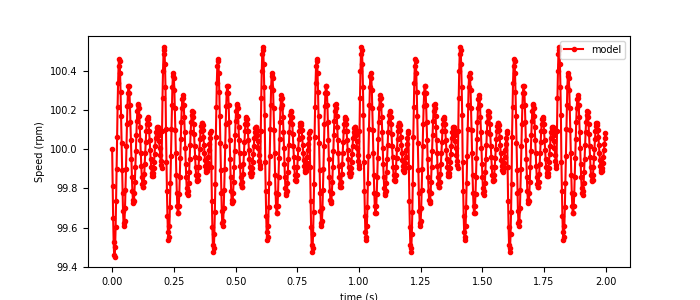

Text(0.5, 0, 'time (s)')

Text(0, 0.5, 'Speed (rpm)')

In [26]:
# for debug

#plt.rcParams['figure.figsize'] = [6, 3]
# %matplotlib inline

A =-0.6
t0  = 0
tau = 9
omega = 2*np.pi*26
c = 100
t1 = 0.218
t2 = 0
T = 0.20
TT = 0.40
# n_max = 12

#par = [A, t0, tau, omega, c, t1, t2, T]

plt.plot(t,h(A, t0,tau, omega, c, t1, t2, T,TT), '-r.')#,t, v, 'b-o')
plt.xlabel('time (s)')
plt.ylabel('Speed (rpm)')
plt.legend(['model','data'])
plt.show()

In [27]:
# obj3

#x0 = (m+M)/2
#sigma0 = (M-m)/4
x0 = (domain[0]+domain[1])/2
sigma0 = (domain[1]-domain[0])/4    


#res = cma.CMAEvolutionStrategy(x0, 1, inopts={'popsize':2000, 'CMA_stds':sigma0,'fixed_variables':{5:0.218, 6:0, 7:0.204}}) 
res_2 = cma.CMAEvolutionStrategy(x0, 1, inopts = {'popsize':3500, 'CMA_stds':sigma0, 'bounds':[domain[0], domain[1]], 'fixed_variables':{ 7:0.20, 8:0.4}}) 
res_2.optimize(obj3, iterations=2000)

(1750_w,3500)-aCMA-ES (mu_w=881.6,w_1=0%) in dimension 7 (seed=984511, Wed Mar  6 15:45:44 2019)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1   3500 2.300011252507831e-01 1.0e+00 1.00e+00  3e-02  6e+01 0:08.2
    2   7000 2.297703375805149e-01 4.7e+00 1.05e+00  3e-02  6e+01 0:15.8
    3  10500 2.185462324561193e-01 1.2e+01 1.10e+00  2e-02  6e+01 0:22.9
    4  14000 1.980954760634978e-01 1.7e+01 1.20e+00  2e-02  6e+01 0:30.7
    5  17500 2.370229325554465e-01 2.4e+01 1.31e+00  2e-02  6e+01 0:37.3
    6  21000 2.098425845575133e-01 3.1e+01 1.34e+00  1e-02  6e+01 0:43.9
    7  24500 2.046523292027847e-01 3.6e+01 1.47e+00  1e-02  6e+01 0:50.7
    9  31500 2.241102978483796e-01 4.7e+01 1.56e+00  1e-02  5e+01 1:04.2
   11  38500 2.021721891383224e-01 5.7e+01 1.73e+00  1e-02  4e+01 2:55.9
   13  45500 1.864295232826072e-01 6.4e+01 1.86e+00  1e-02  3e+01 3:09.6
   15  52500 1.952651697558344e-01 6.6e+01 1.94e+00  1e-02  2e+01 3:22.9
   17  59500 1.9935938746503

In [28]:
res_2.result_pretty()

termination on tolfunhist=1e-12
final/bestever f-value = 1.611292e-01 1.562582e-01
incumbent solution: [0.6764957777807622, 2.0369063336357973e-18, 12.199022040521688, 177.11563280007115, 100.0000980007339, 0.159029071110124, 0.023650172742740946, 0.2, 0.4]
std deviation: [0.00028466023015846103, 1.227532273101408e-08, 6.308509419100115e-06, 3.2988773035663387e-06, 4.1497303210635215e-08, 0.0005268464016735502, 3.601771855457572e-07]


CMAEvolutionStrategyResult(xbest=array([-6.53662499e-01,  1.43396909e-02,  8.57873279e+00,  1.63702224e+02,
        1.00005598e+02,  1.25692239e-01,  5.67604599e-03,  2.00000000e-01,
        4.00000000e-01]), fbest=0.1562581966230356, evals_best=97011, evaluations=381500, iterations=109, xfavorite=array([ 7.59135164e-01, -5.00000006e-02,  1.21990220e+01,  1.77115633e+02,
        1.00000094e+02,  1.60137520e-01,  1.87752466e-02,  2.00000000e-01,
        4.00000000e-01]), stds=array([2.84660230e-04, 1.22753227e-08, 6.30850942e-06, 3.29887730e-06,
       4.14973032e-08, 5.26846402e-04, 3.60177186e-07]))

In [29]:
out_2 = res_2.result.xbest

print('out_2 = [A, t0, tau, omega, c, t1, t2, T] =') 
print('      =', out_2)
print('expected values = [...]')
print('error_2 =', obj3(out_2))

out_2 = [A, t0, tau, omega, c, t1, t2, T] =
      = [-6.53662499e-01  1.43396909e-02  8.57873279e+00  1.63702224e+02
  1.00005598e+02  1.25692239e-01  5.67604599e-03  2.00000000e-01
  4.00000000e-01]
expected values = [...]
error_2 = 0.1562581966230356


<IPython.core.display.Javascript object>


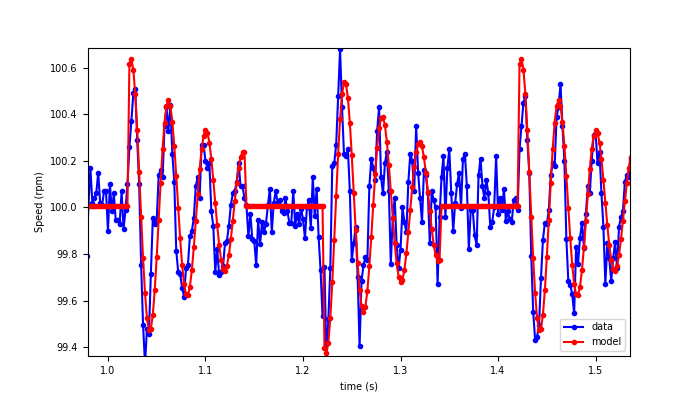

Text(0.5, 0, 'time (s)')

Text(0, 0.5, 'Speed (rpm)')

In [46]:

[A, t0, tau, omega, c, t1, t2, T, TT] = out_2

#plt.plot(t, h(out), '-ro')
plt.plot(t, v, '-b.', t, h(A, t0, tau, omega, c, t1, t2, T, TT), '-r.')
plt.xlabel('time (s)')
plt.ylabel('Speed (rpm)')
plt.legend(['data','model'])
plt.show()

In [31]:
backlash_est_2 = abs(out_2[0])
backlash_est_2 

0.6536624992635869

In [32]:
out_2[2]

8.578732785779119

In [33]:
out_2[3]

163.70222397293696

In [35]:
backlash_est_1

0.5150556915914648

In [36]:
out_1[2]

11.018647490263142

In [37]:
out_1[3]

164.9820942607794

<IPython.core.display.Javascript object>


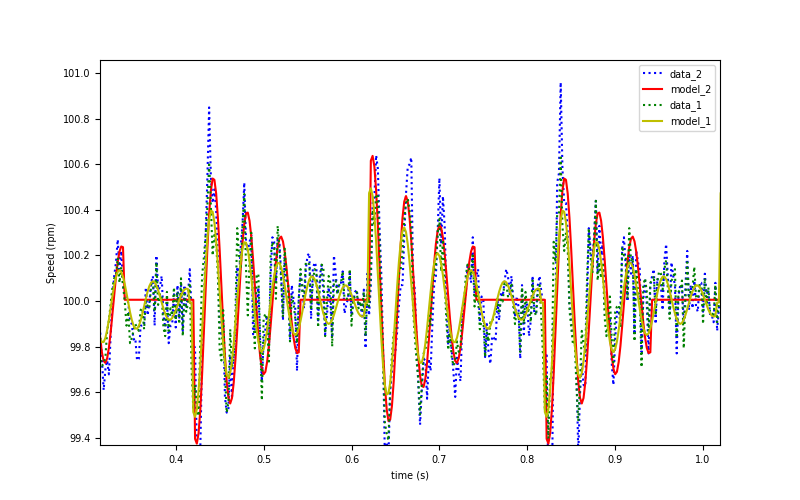

Text(0.5, 0, 'time (s)')

Text(0, 0.5, 'Speed (rpm)')

In [39]:
[A, t0, tau, omega, c, t1, t2, T, TT] = out_2
func_2 = h(A, t0, tau, omega, c, t1, t2, T, TT)

[A, t0, tau, omega, c, t1, t2, T, TT] = out_1
func_1 = h(A, t0, tau, omega, c, t1, t2, T, TT)

plt.rcParams['figure.figsize'] = [8, 5]
#plt.plot(t, h(out), '-ro')
plt.plot(t, v, ':b', t, func_2, '-r')
plt.plot(t_1, v_1, ':g', t_1, func_1, '-y')

plt.xlabel('time (s)')
plt.ylabel('Speed (rpm)')
plt.legend(['data_2','model_2','data_1','model_1'])
plt.show()